<a href="https://colab.research.google.com/github/109065431/sample_data/blob/main/sample_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install packages
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from textblob import TextBlob
import spacy
import nltk

In [2]:
!pip install contractions
import contractions

In [3]:
!pip install transformers
from transformers import pipeline

In [4]:
def fix_word_contraction(UserB_1st_turn_msg):
    #The function for fixing word contraction e.g. isn't --> is not
    expanded_words = []
    for word in UserB_1st_turn_msg.split():
      #Fixing word contractions
      expanded_words.append(contractions.fix(word))

    expanded_text = ' '.join(expanded_words)
    return expanded_text

In [5]:
def clean_text(UserB_1st_turn_msg):
    #The function for cleaning text before analyzing emotion classification

    UserB_1st_turn_msg = re.sub(r"\@USER", " ", UserB_1st_turn_msg) #Remove "@user"
    UserB_1st_turn_msg = re.sub(r"\[URL\]", " ", UserB_1st_turn_msg) #Remove "[url]"
    #UserB_1st_turn_msg = demoji.replace(UserB_1st_turn_msg, " ") #Remove emojis

    html_tag = re.compile(r'<[^>]+>')
    UserB_1st_turn_msg = html_tag.sub('', UserB_1st_turn_msg) #Remove HTML tag
    #UserB_1st_turn_msg = re.sub(r"[^0-9A-Za-z\s]+", " ", UserB_1st_turn_msg) #Remove all special characters except number/./,/'

    UserB_1st_turn_msg = re.sub(r"[^0-9A-Za-z\s.',]+", " ", UserB_1st_turn_msg) #Remove all special characters except number/./,/' since they are the punctuations separating the sentences, clauses, and possessive nouns
    UserB_1st_turn_msg = re.sub("\s+", " ", UserB_1st_turn_msg) #Replace any spaces to 1 space
    UserB_1st_turn_msg = re.sub("^\s+", "", UserB_1st_turn_msg) #Remove any space(s) if it's at the beginning

    return UserB_1st_turn_msg

In [6]:
def polarity(text):
    #Sentiment analysis By Textblob library (Lexicon-based method)
    #polarity: [-1,1] where 1 is positive and -1 is negative polarity.
    return TextBlob(text).sentiment.polarity

In [7]:
#read data from csv file in Github
data = pd.read_csv('https://raw.githubusercontent.com/109065431/sample_data/main/sampled_data.csv')

In [8]:
data.head()


,Conversation,Offense,Non_intention,UserB_1st_turn_msg,Contextual_dependence,Target
0,"<span style=""color: #F87217;"">User A</span>: ""...",54.666667,69.666667,@USER duuuuuhhh fucccckkk... You need a trimmi...,91.333333,True
1,"<span style=""color: #F87217;"">User A</span>: ""...",57.333333,60.000000,@USER <span class='emoji-bytes' data-emoji-byt...,80.333333,True
2,"<span style=""color: #F87217;"">User A</span>: ""...",65.000000,96.666667,"@USER fuck, i love when bath follows people!",47.333333,False
3,"<span style=""color: #F87217;"">User A</span>: ""...",40.000000,92.666667,@USER Geez Doug. Just an opinion my man. We'll...,58.333333,False
4,"<span style=""color: #F87217;"">User A</span>: ""...",48.000000,95.000000,@USER I think I know the answer. But hope you ...,65.333333,False


In [9]:
#Fix word contraction and clean text respectively
data['UserB_1st_turn_msg_preprocessed'] = [fix_word_contraction(UserB_1st_turn_msg) for UserB_1st_turn_msg in data['UserB_1st_turn_msg']]
data['UserB_1st_turn_msg_preprocessed'] = [clean_text(Bmessg) for Bmessg in data['UserB_1st_turn_msg_preprocessed']]

In [10]:
#Binarize the data (Target >= True : 1, else:0)
data["Target"] = np.where((data['Target'] == "True"), 1, 0)

In [11]:
#Seperate data based on conditions e.g. offense, non_intention
data_Off = data[(data['Offense'] >= 50)] #Offensive messages
data_Off.reset_index(inplace = True, drop=True)

In [12]:
#Seperate data based on conditions e.g. offense, non_intention
data_IntOff = data[(data['Offense'] >= 50) & (data['Non_intention'] < 50)] #Intentionally offensive messages
data_IntOff.reset_index(inplace = True, drop=True)
data_IntOff = data_IntOff.copy()

data_UnIntOff = data[(data['Offense'] >= 50) & (data['Non_intention'] >= 50)] #Unintentionally offensive messages
data_UnIntOff.reset_index(inplace = True, drop=True)
data_IntOff = data_IntOff.copy()

In [13]:
#Down sampling unintentionally offensive messages
len_IntOff = len(data_IntOff)  #To sample data from data_UnIntOff equally to this number
data_UnIntOff_down_sampling = data_UnIntOff.sample(n = len_IntOff, random_state = 12, replace = False)
data_UnIntOff_down_sampling.reset_index(inplace = True, drop=True)

data_UnIntOff_IntOff = pd.concat([data_UnIntOff_down_sampling , data_IntOff], axis=0) #Unintentionally offensive messages (downsampled) equals to intentionally offensive messages
data_UnIntOff_IntOff.reset_index(inplace = True, drop=True)


**Create heatmap to see correlation of three factors which are offense, non-intention, and contextual dependence of the messages**

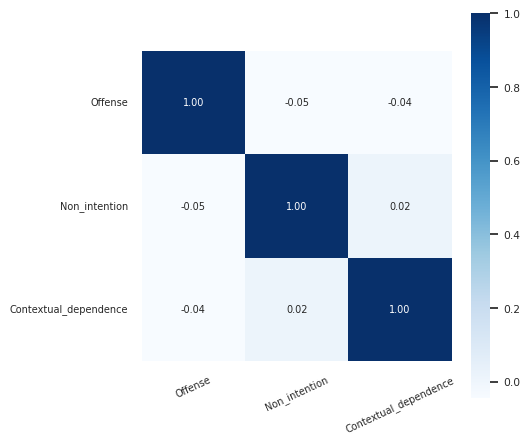

In [14]:
plt.style.use("ggplot") #Styling
rcParams['figure.figsize'] = (5, 5)

corrmat = data_UnIntOff_IntOff[['Offense', 'Non_intention', 'Contextual_dependence']].corr()
sns.set(font_scale=0.7)
hm = sns.heatmap(corrmat,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 7},
                 yticklabels=corrmat.columns,
                 xticklabels=corrmat.columns,
                 cmap="Blues")

hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 7, rotation=25)
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 7, rotation=0)
plt.show()

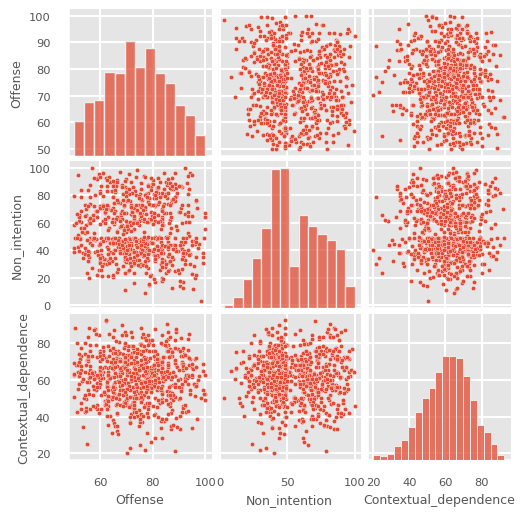

In [15]:
#Create pair plot to see how the data is distributed in each pair of three factors (offense, non-intention, and contextual dependence)
plt.style.use("ggplot") #Styling
data_Off_pair_plot = data_UnIntOff_IntOff[['Offense', 'Non_intention', 'Contextual_dependence']]
sns.set_context("paper", rc={"axes.labelsize":5})
sns.set_context("talk", font_scale=0.5)
pair_plot = sns.pairplot(data_Off_pair_plot, plot_kws={"s": 10})
pair_plot.fig.set_size_inches(5, 5)
plt.show()

From the figures of heatmap and pair plot between each factor, there is no pair of factors that was significantly correlated to each other. This is because unintentionally offensive language is very subjective to individuals. That's why the message can lead to unintentionally offensive conversation (miscommunication).

**Create a comparison of the polarity score between unintentionally offensive messages and intentionally offensive messages**

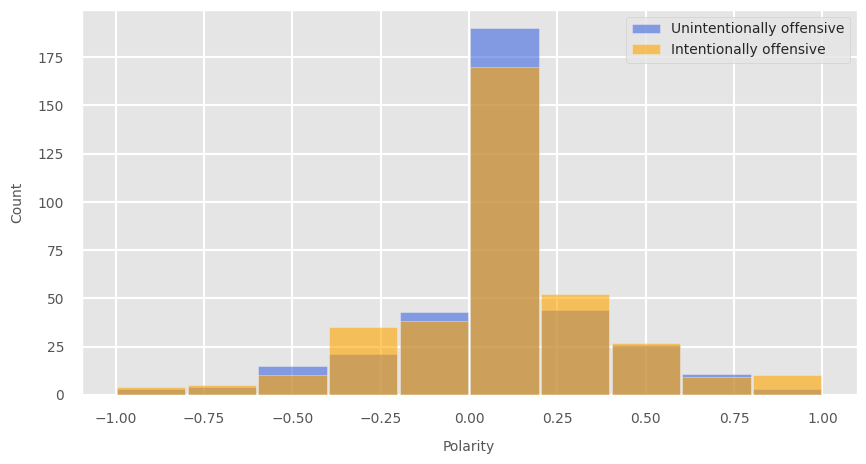

In [16]:
#The comparison of the polarity score between unintentionally offensive messages and intentionally offensive messages
data_UnIntOff_IntOff['UserB_1st_turn_msg_polarity'] = [polarity(UserB_1st_turn_msg) for UserB_1st_turn_msg in data_UnIntOff_IntOff['UserB_1st_turn_msg_preprocessed']]
data_UnIntOff_IntOff["Non_intention_binarized"] = np.where((data_UnIntOff_IntOff['Non_intention'] >= 50), "Unintentionally offensive", "Intentionally offensive") #Binarize the data

UnIntOff = data_UnIntOff_IntOff.loc[data_UnIntOff_IntOff["Non_intention_binarized"] == 'Unintentionally offensive', 'UserB_1st_turn_msg_polarity']
IntOff = data_UnIntOff_IntOff.loc[data_UnIntOff_IntOff["Non_intention_binarized"] == 'Intentionally offensive', 'UserB_1st_turn_msg_polarity']

#Plot bar chart
plt.style.use("ggplot") #Styling
rcParams['figure.figsize'] = (10, 5) #width, height

plt.hist(UnIntOff, color = "royalblue", rwidth=0.97, alpha = 0.6, label = 'Unintentionally offensive', bins = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.hist(IntOff, color = "orange", rwidth=0.97, alpha = 0.6, label = 'Intentionally offensive', bins = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.xlabel('Polarity', fontsize=10, labelpad=10)
plt.ylabel('Count', fontsize=10, labelpad=10)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)

plt.legend(loc='upper right', fontsize = 10)
#plt.legend(title='Offensive types')
plt.show()

From the above figure which compared the polarity between unintentionally offensive and intentionally offensive
messages by utilizing TextBlob, a python library which is a lexicon-based analyzer
to calculate the polarity of messages for both classes. The polarity score is between -1 and
1 where -1 indicates a negative sentiment in which the text is likely to express negative
emotions such as anger, frustration, disappointment, sadness, fear, or disgust. While a polarity
score of 1 indicates a positive sentiment in which the text is likely to express positive
emotions such as happiness, joy, excitement, love, gratitude, or satisfaction. The result showed that unintentionally offensive messages are very subtle, as most messages cannot be detected as offensive by the
lexicon-based analyzer.

**Create word clouds for both intentionally offensive and unintentionally offensive messages**

Regarding the result of polarity score, let's see the words mostly used between unintentionally
offensive and intentionally offensive messages by using word cloud as below

In [17]:
nltk.download('wordnet')
en_model = spacy.load('en_core_web_sm') #Spacy stopwords
stop = en_model.Defaults.stop_words
stop.update(['ll', 've', 'doe', 'wa', 'ha']) #Update stop words

#Create WordNetLemmatizer object
wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


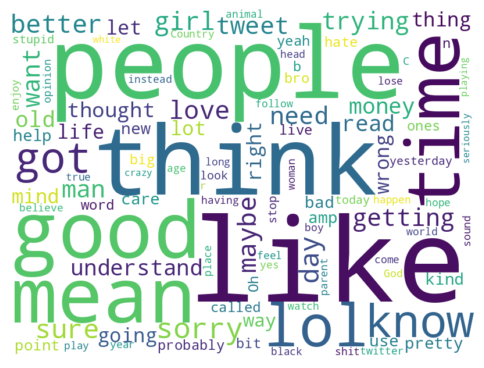

In [18]:
#Word cloud of unintentionally offensive messages (down sampled)
#The words that were frequently used in the unintentionally offensive messages
text = " ".join(word for word in data_UnIntOff_down_sampling['UserB_1st_turn_msg_preprocessed'])
text = wnl.lemmatize(text)

rcParams['figure.figsize'] = (6, 6) #width, height
wordcloud = WordCloud(stopwords=stop, max_font_size=200, max_words=100, background_color="white", width=800, height=600).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

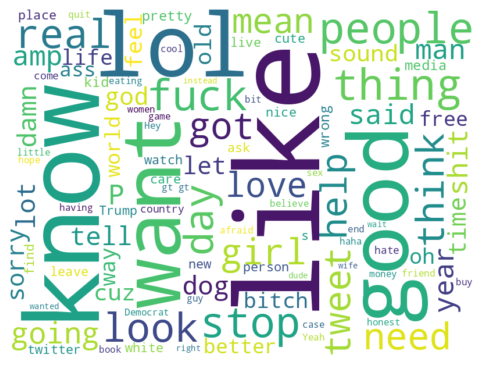

In [19]:
#Word cloud of intentionally offensive messages
#The word frequently used in the intentionally offensive messages
text = " ".join(word for word in data_IntOff['UserB_1st_turn_msg_preprocessed'])
text = wnl.lemmatize(text)

rcParams['figure.figsize'] = (6, 6) #width, height
wordcloud = WordCloud(stopwords=stop, max_font_size=200, max_words=100, background_color="white", width=800, height=600).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Create a comparison of the emotion between unintentionally offensive messages and intentionally offensive messages**

Let's use a more fine-grained analyzer to analyze the messages between unintentionally offensive
and intentionally offensive messages. The RoBERTa-based classification model
will be used.

In [20]:
#Load the emotion classification model from the Hugging Face resource
emotion = pipeline('sentiment-analysis', model='arpanghoshal/EmoRoBERTa')

def emotion_classification(text):
  #Identify emotion of each message
    emotion_label = emotion(text)[0]['label']
    return emotion_label

data_UnIntOff_down_sampling['Emotion'] = [emotion_classification(text) for text in data_UnIntOff_down_sampling['UserB_1st_turn_msg_preprocessed']]
data_IntOff['Emotion'] = [emotion_classification(text) for text in data_IntOff['UserB_1st_turn_msg_preprocessed']]

emo_UnIntOff = data_UnIntOff_down_sampling.groupby('Emotion')['Emotion'].count()
emo_UnIntOff = pd.DataFrame(emo_UnIntOff)
emo_UnIntOff.rename(columns = {'Emotion':'Count'}, inplace = True)

emo_IntOff = data_IntOff.groupby('Emotion')['Emotion'].count()
emo_IntOff = pd.DataFrame(emo_IntOff)
emo_IntOff.rename(columns = {'Emotion':'Count'}, inplace = True)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [21]:
#Find common emotions between unintentionally and intentionally offensive messages
def common_emotion(list1, list2):
    emo = [i for i in list1 if i in list2]
    return emo
emo_common = common_emotion(list(emo_IntOff.index), list(emo_UnIntOff.index))

emo_IntOff = emo_IntOff[emo_IntOff.index.isin(emo_common)]
emo_UnIntOff = emo_UnIntOff[emo_UnIntOff.index.isin(emo_common)]
emo_UnIntOff = list(emo_UnIntOff['Count'])
emo_IntOff = list(emo_IntOff['Count'])

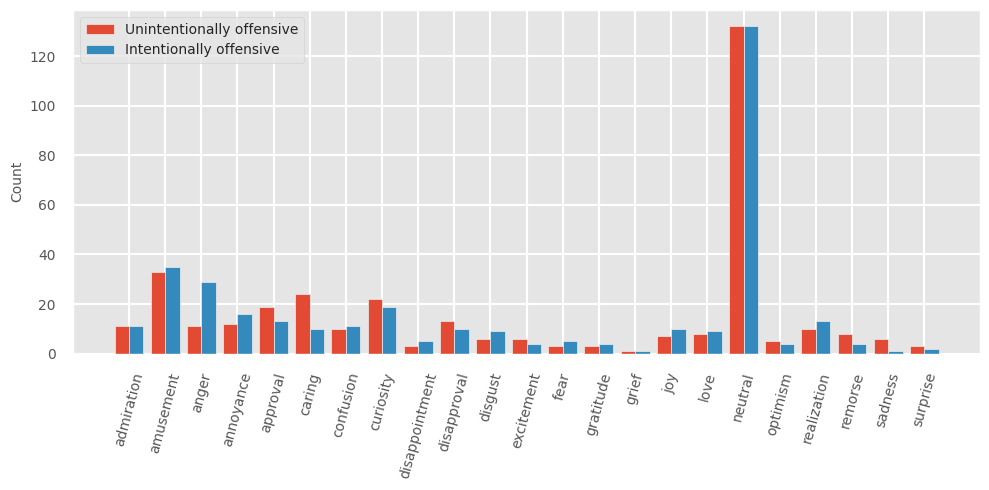

In [22]:
#The comparison of the emotion classification result between unintentionally offensive messages and intentionally offensive messages
plt.style.use("ggplot") #Styling
rcParams['figure.figsize'] = (10,  5) #width, height

x = np.arange(len(emo_common))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, emo_UnIntOff, width, label='Unintentionally offensive')
rects2 = ax.bar(x + width/2, emo_IntOff, width, label='Intentionally offensive')

# Customize label, x-axis and y-axis, etc.
ax.set_xticks(x, emo_common)
ax.legend()
ax.set_ylabel("Count", fontsize=10)

import matplotlib.ticker as ticker
ax.yaxis.set_major_locator(ticker.FixedLocator([0, 20, 40, 60, 80, 100, 120, 140, 160]))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(['0', '20', '40', '60', '80', '100', '120', '140', '160']))
ax.set_yticklabels(['{:,.0f}'.format(y) for y in ax.get_yticks()], fontsize=80)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=75)

ax.legend(prop={'size': 10})
fig.tight_layout()
plt.show()

From the above figure, the results showed that intentionally offensive language had a higher
proportion of anger, annoyance, and disgust than unintentional offensive language.
While unintentionally offensive language had a higher proportion of approval, caring,
curiosity, and sadness than intentionally offensive language. This showed that unintentionally offensive messages appeared less proportion
of negative sentiment than intentionally offensive messages. Moreover, the result pointed out that the classification model detecting unintentionally offensive messages should not rely on offensive lexicon only, but the model should be developed with more advance algorithm than Roberta-based model for better classification